# Signal-level EDA ds003029 — 4 characteristics + domain IO

Mục tiêu notebook này:
- EDA **tín hiệu iEEG/ECoG/SEEG** (BrainVision: `.vhdr/.vmrk/.eeg`) sau khi bạn đã `git annex get` các run
- Trích xuất và minh hoạ **4 characteristics** quan trọng của time series phục vụ seizure detection
- Trả lời câu hỏi domain/modeling: **input là gì (shape), feature là gì, output/label là gì**

Gợi ý cách chạy:
1) Chạy lần lượt các cell
2) Bắt đầu bằng QC metadata + load thử 1–2 run
3) Sau đó chạy phần windowing + feature extraction (nhẹ)

In [1]:
from __future__ import annotations

import json
import math
import warnings
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional dependencies for signal work
try:
    import mne
except Exception as e:
    mne = None
    print('mne not available:', e)

try:
    from scipy.signal import welch
except Exception as e:
    welch = None
    print('scipy not available:', e)

np.random.seed(0)
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (10, 4)

## 0) Config

Bạn có thể chỉnh các tham số sau:
- `N_RUNS_METADATA`: số run để thống kê metadata (nhẹ)
- `N_RUNS_HEAVY`: số run để làm EDA sâu (crop quanh seizure + PSD + feature)
- `WINDOW_SEC`, `STEP_SEC`: windowing cho dataset modeling

In [2]:
DATASET_ROOT = Path('EEG') / 'ds003029'
assert DATASET_ROOT.exists(), f'Không thấy dataset tại: {DATASET_ROOT.resolve()}'

RUN_SUMMARY_CSV = Path('eda_outputs') / 'ds003029_run_summary.csv'
assert RUN_SUMMARY_CSV.exists(), (
    'Không thấy eda_outputs/ds003029_run_summary.csv. '
    'Hãy export từ notebook EDA metadata (Phần 2.4) trước.'
)

N_RUNS_METADATA = 15
N_RUNS_HEAVY = 3

WINDOW_SEC = 2.0
STEP_SEC = 1.0
MAX_CHANNELS = 16  # giới hạn kênh để chạy nhanh

# Crop quanh seizure: pre/post margin (giây)
PRE_SEC = 120.0
POST_SEC = 120.0

print('Dataset root:', DATASET_ROOT.resolve())
print('Run summary:', RUN_SUMMARY_CSV.resolve())

Dataset root: C:\Users\LENOVO\Downloads\eeg\EEG\ds003029
Run summary: C:\Users\LENOVO\Downloads\eeg\eda_outputs\ds003029_run_summary.csv


## 1) Domain IO: input/output là gì?

**Seizure detection** thường được cast thành 1 trong 2 bài toán:

### (A) Window classification (khuyến nghị để bắt đầu)
- **Input** $X$: các cửa sổ tín hiệu ngắn (vd 2s) từ nhiều kênh
  - Dạng raw: `X_raw.shape = (n_windows, n_channels, n_samples)`
  - Dạng features: `X_feat.shape = (n_windows, n_features)`
- **Output** $y$: nhãn cho mỗi window
  - binary: `ictal` vs `non-ictal`
  - hoặc 3-class: `interictal / preictal / ictal`

### (B) Sequence labeling / onset detection
- **Input**: chuỗi windows theo thời gian
- **Output**: xác suất theo thời gian hoặc timestamp onset/offset

Notebook này sẽ EDA và demo pipeline theo hướng (A), vì dễ ra hình + dễ báo cáo + phù hợp khi dữ liệu chưa quá nhiều.

In [3]:
run_summary = pd.read_csv(RUN_SUMMARY_CSV)
print('run_summary shape:', run_summary.shape)
display(run_summary.head())

# Columns we expect
needed = ['base', 'subject', 'acq', 'has_onset', 'has_offset', 'seizure_onset_s', 'seizure_offset_s']
missing = [c for c in needed if c not in run_summary.columns]
print('Missing expected cols:', missing)

eeg_present_col = 'eeg_content_present' if 'eeg_content_present' in run_summary.columns else ('eeg_present' if 'eeg_present' in run_summary.columns else None)
assert eeg_present_col is not None, 'run_summary thiếu cột eeg_content_present/eeg_present'
print('Using eeg present column:', eeg_present_col)

run_summary shape: (106, 28)


,subject,session,task,acq,run,suffix,base,events_tsv,channels_tsv,ieeg_json,vhdr,vmrk,eeg,n_channels,n_good,n_bad,type_counts,sfreq,line_freq,has_onset,has_offset,seizure_onset_s,seizure_offset_s,seizure_duration_s,eeg_worktree_exists,eeg_content_present,eeg_present,eeg_size_bytes
0,jh101,presurgery,ictal,ecog,1,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,58.950,79.875,20.925,True,True,True,76788000
1,jh101,presurgery,ictal,ecog,2,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,66.825,275.850,209.025,True,True,True,182614500
2,jh101,presurgery,ictal,ecog,3,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,58.950,79.875,20.925,True,True,True,76788000
3,jh101,presurgery,ictal,ecog,4,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,58.950,84.825,25.875,True,False,False,69
4,jh102,presurgery,ictal,ecog,1,ieeg,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,123,115,8,"{'ECOG': 115, 'MISC': 8}",1000.0,60,True,True,54.834,333.944,279.110,True,True,True,189942012


Missing expected cols: []
Using eeg present column: eeg_content_present


In [4]:
rs = run_summary.copy()
rs['base'] = rs['base'].astype(str)
rs['_has_onset_offset'] = rs.get('has_onset', False).astype(bool) & rs.get('has_offset', False).astype(bool)
rs['_eeg_ok'] = rs[eeg_present_col].astype(bool)

# Prioritize runs with onset+offset and EEG content
cand = rs[rs['_eeg_ok']].copy()
cand['_priority'] = 0
cand.loc[cand['_has_onset_offset'], '_priority'] += 10
cand.loc[cand.get('acq', '').astype(str).str.lower().isin(['ecog', 'seeg']), '_priority'] += 1
cand['_n_channels'] = pd.to_numeric(cand.get('n_channels', np.nan), errors='coerce')
cand['_priority'] += cand['_n_channels'].fillna(0) / 100.0

cand = cand.sort_values(['_priority'], ascending=False)
meta_runs = cand.head(N_RUNS_METADATA).copy()
heavy_runs = cand.head(N_RUNS_HEAVY).copy()

print('Selected for metadata:', len(meta_runs))
print('Selected for heavy EDA:', len(heavy_runs))
display(heavy_runs[['subject','acq','run','sfreq','n_channels','n_bad','has_onset','has_offset','seizure_onset_s','seizure_offset_s','base']].head(10))

Selected for metadata: 15
Selected for heavy EDA: 3


,subject,acq,run,sfreq,n_channels,n_bad,has_onset,has_offset,seizure_onset_s,seizure_offset_s,base
0,jh101,ecog,1,1000.0,135,26,True,True,58.950,79.875,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
1,jh101,ecog,2,1000.0,135,26,True,True,66.825,275.850,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
2,jh101,ecog,3,1000.0,135,26,True,True,58.950,79.875,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...


## 2) Helpers: load BrainVision + chọn kênh + feature functions

Chú ý:
- Có run `.vhdr` không chuẩn → code sẽ skip và log lỗi
- Không preload cả file (rất lớn); chỉ crop 1 đoạn quanh seizure để EDA

In [5]:
def is_valid_brainvision_vhdr(vhdr_path: Path) -> bool:
    try:
        text = vhdr_path.read_text(encoding='utf-8', errors='ignore')
    except Exception:
        return False
    return ('[Common Infos]' in text) or ('[Common infos]' in text)


def paths_from_base(base: str) -> dict[str, Path]:
    p = Path(base)
    return {
        'vhdr': Path(str(p) + '.vhdr'),
        'vmrk': Path(str(p) + '.vmrk'),
        'eeg': Path(str(p) + '.eeg'),
        'events': Path(str(p)).with_name(p.name.replace('_ieeg', '_events.tsv')),
        'channels': Path(str(p)).with_name(p.name.replace('_ieeg', '_channels.tsv')),
    }


def read_events_tsv(events_path: Path) -> pd.DataFrame | None:
    if not events_path.exists():
        return None
    try:
        return pd.read_csv(events_path, sep='\t')
    except Exception as e:
        print('Cannot read events:', events_path, e)
        return None


def read_channels_tsv(ch_path: Path) -> pd.DataFrame | None:
    if not ch_path.exists():
        return None
    try:
        return pd.read_csv(ch_path, sep='\t')
    except Exception as e:
        print('Cannot read channels:', ch_path, e)
        return None


def pick_good_ieeg_channels(ch_df: pd.DataFrame | None, max_channels: int = 16) -> list[str]:
    if ch_df is None or len(ch_df) == 0:
        return []
    df = ch_df.copy()
    if 'status' in df.columns:
        df = df[df['status'].astype(str).str.lower().eq('good')]
    if 'type' in df.columns:
        df = df[df['type'].astype(str).str.upper().isin(['ECOG', 'SEEG'])]
    if 'name' not in df.columns:
        return []
    names = df['name'].astype(str).tolist()
    return names[:max_channels]


def compute_bandpower(psd: np.ndarray, freqs: np.ndarray, fmin: float, fmax: float) -> float:
    mask = (freqs >= fmin) & (freqs <= fmax)
    if not np.any(mask):
        return float('nan')
    return float(np.trapz(psd[mask], freqs[mask]))


def spectral_entropy(psd: np.ndarray, eps: float = 1e-12) -> float:
    p = psd.astype(float)
    p = p / (np.sum(p) + eps)
    return float(-np.sum(p * np.log(p + eps)))


def hjorth_parameters(x: np.ndarray, eps: float = 1e-12) -> tuple[float, float, float]:
    # x: (n_samples,)
    x = x.astype(float)
    dx = np.diff(x)
    ddx = np.diff(dx)
    var0 = np.var(x) + eps
    var1 = np.var(dx) + eps
    var2 = np.var(ddx) + eps
    activity = var0
    mobility = math.sqrt(var1 / var0)
    complexity = math.sqrt(var2 / var1) / (mobility + eps)
    return float(activity), float(mobility), float(complexity)

## 3) Metadata QC sau khi annex get

Mục tiêu:
- Xác nhận bạn có bao nhiêu run `eeg_content_present=1`
- Xem phân bố `sfreq`, `n_channels`, và độ dài seizure (nếu có onset/offset)

Runs with EEG content present: 16 / 106
Runs with onset+offset: 73
Runs with onset+offset+eeg: 16


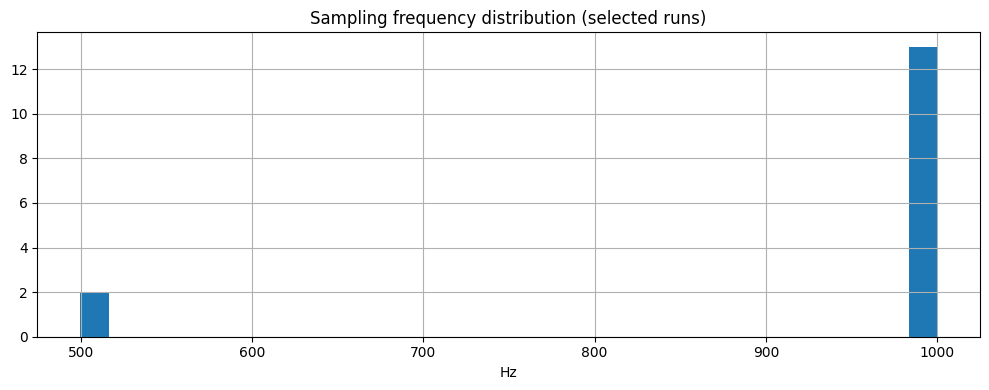

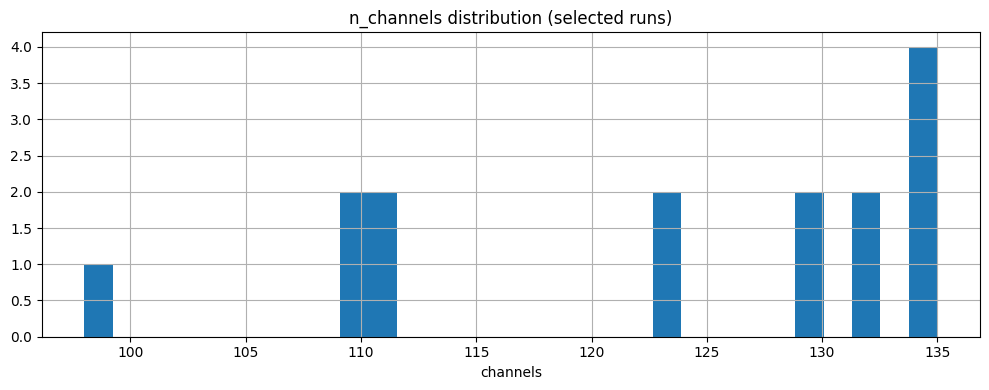

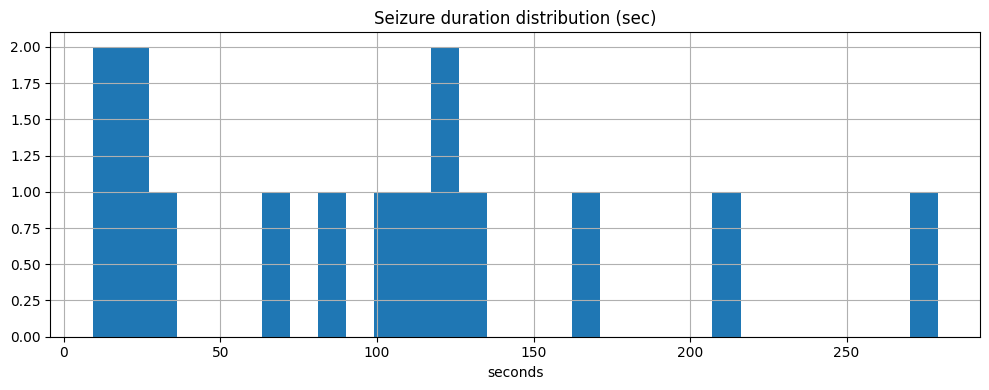

In [6]:
print('Runs with EEG content present:', int(rs[eeg_present_col].astype(bool).sum()), '/', len(rs))
print('Runs with onset+offset:', int((rs.get('has_onset', False).astype(bool) & rs.get('has_offset', False).astype(bool)).sum()))
print('Runs with onset+offset+eeg:', int((rs.get('has_onset', False).astype(bool) & rs.get('has_offset', False).astype(bool) & rs[eeg_present_col].astype(bool)).sum()))

plt.figure()
pd.to_numeric(meta_runs.get('sfreq', np.nan), errors='coerce').dropna().hist(bins=30)
plt.title('Sampling frequency distribution (selected runs)')
plt.xlabel('Hz')
plt.tight_layout()
plt.show()

plt.figure()
pd.to_numeric(meta_runs.get('n_channels', np.nan), errors='coerce').dropna().hist(bins=30)
plt.title('n_channels distribution (selected runs)')
plt.xlabel('channels')
plt.tight_layout()
plt.show()

dur = pd.to_numeric(meta_runs.get('seizure_duration_s', np.nan), errors='coerce').dropna()
if len(dur) > 0:
    plt.figure()
    dur.hist(bins=30)
    plt.title('Seizure duration distribution (sec)')
    plt.xlabel('seconds')
    plt.tight_layout()
    plt.show()

## 4) 4 characteristics của time series (signal-level)

Trong seizure detection, 4 nhóm characteristic thực dụng để mô tả/EDA là:

1) **Scale & distribution / artifacts**: biên độ, RMS, peak-to-peak, clipping, kênh lỗi
2) **Spectral content**: PSD, bandpower (delta..gamma), line noise (50/60Hz), high-frequency activity
3) **Temporal dependence / complexity**: autocorrelation, Hjorth parameters, entropy
4) **Non-stationarity & seizure transition**: feature thay đổi theo thời gian, khác biệt pre/ictal/post

Reading 0 ... 142199  =      0.000 ...   142.199 secs...


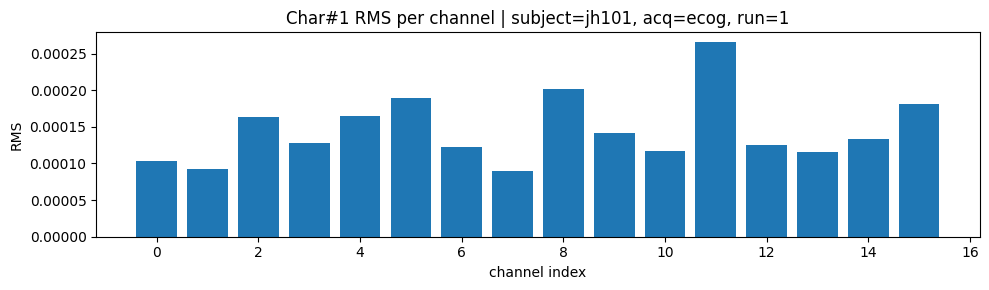

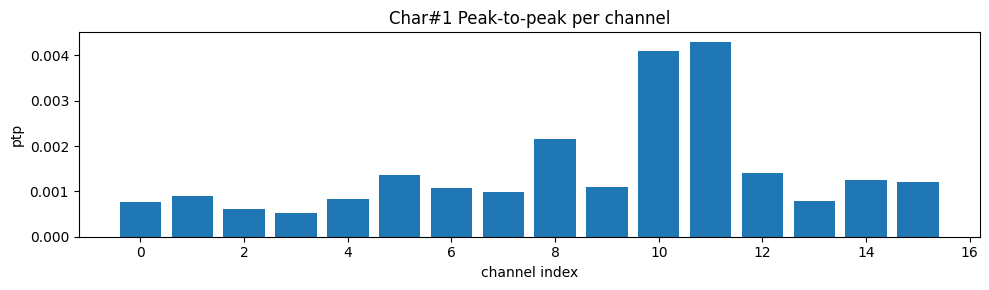

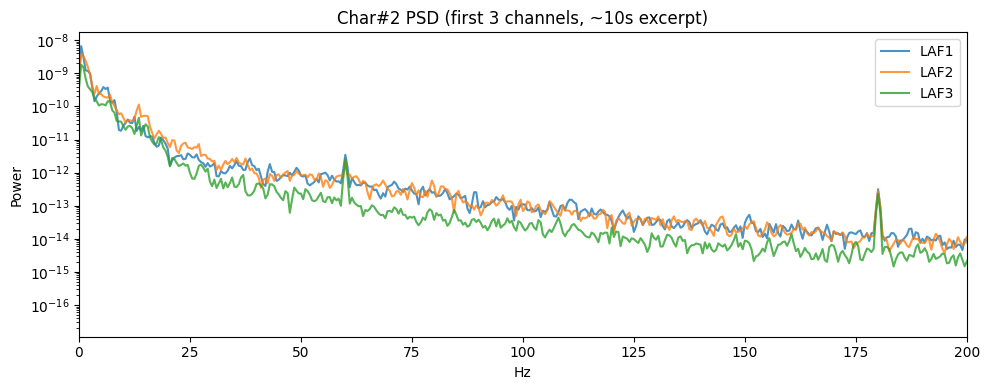

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12292\2210648023.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[mask], freqs[mask]))


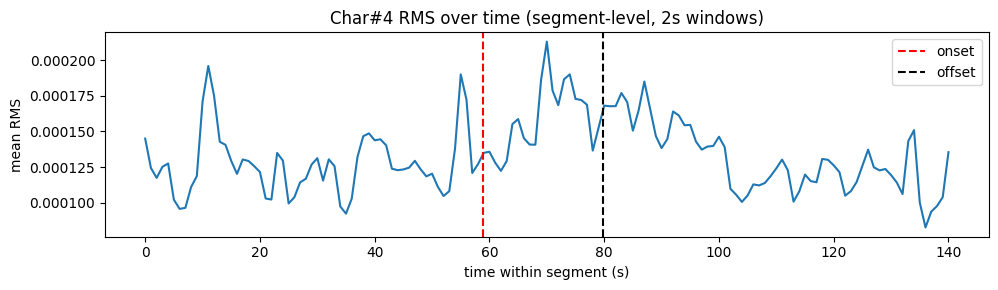

Reading 0 ... 338174  =      0.000 ...   338.174 secs...


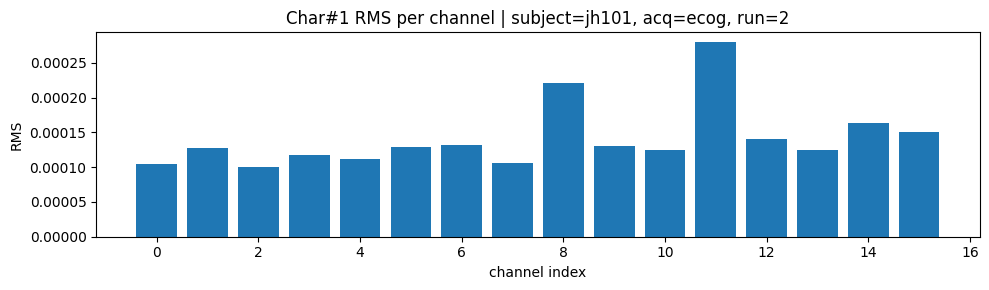

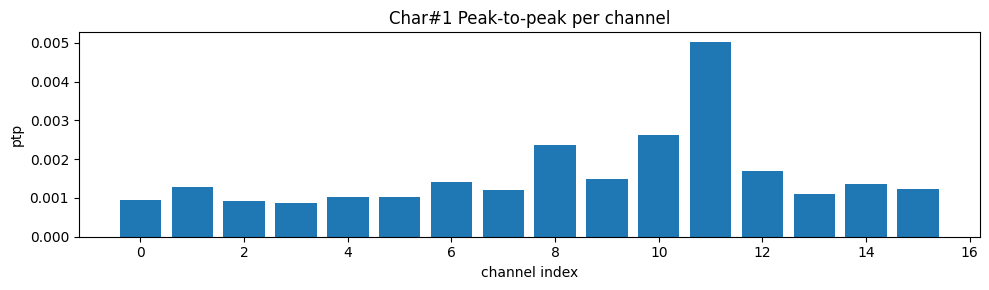

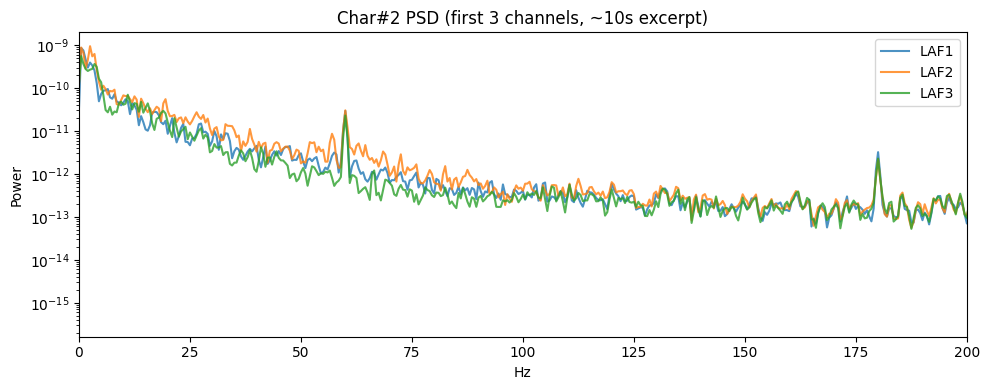

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12292\2210648023.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[mask], freqs[mask]))


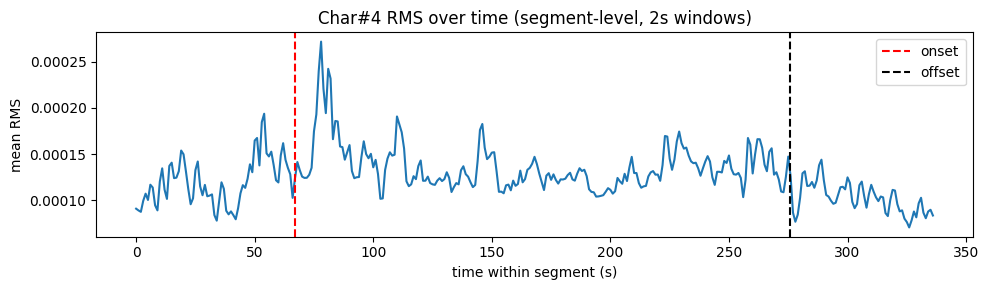

Reading 0 ... 142199  =      0.000 ...   142.199 secs...


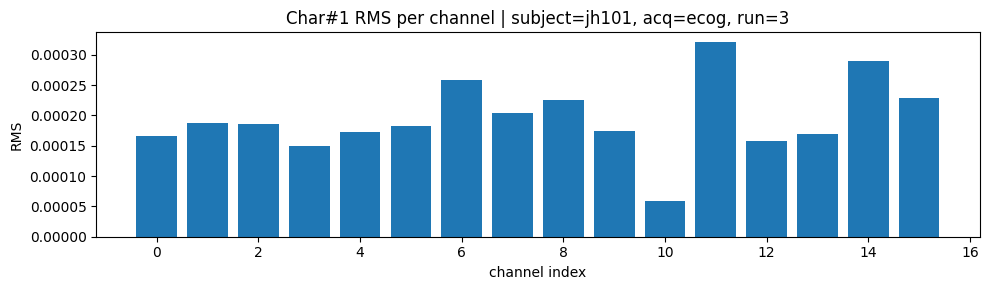

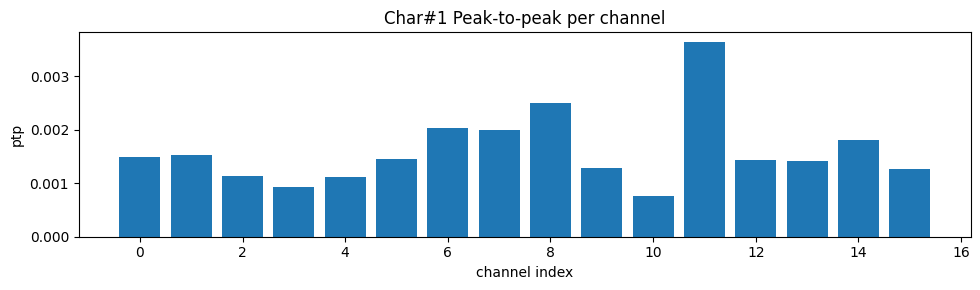

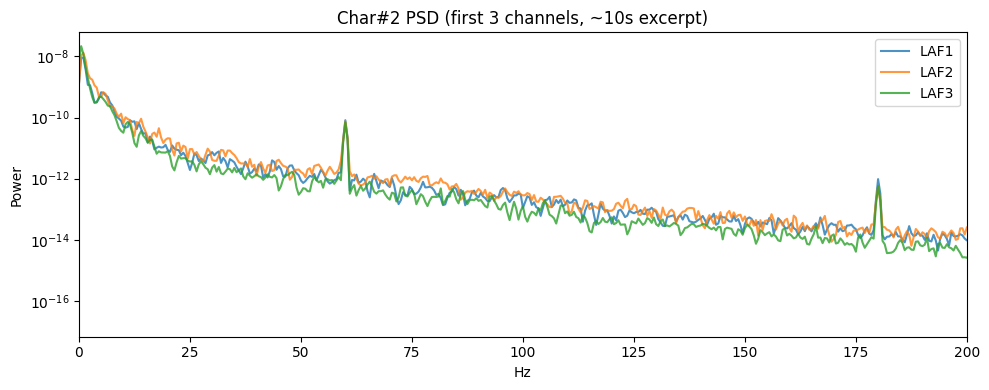

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12292\2210648023.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[mask], freqs[mask]))


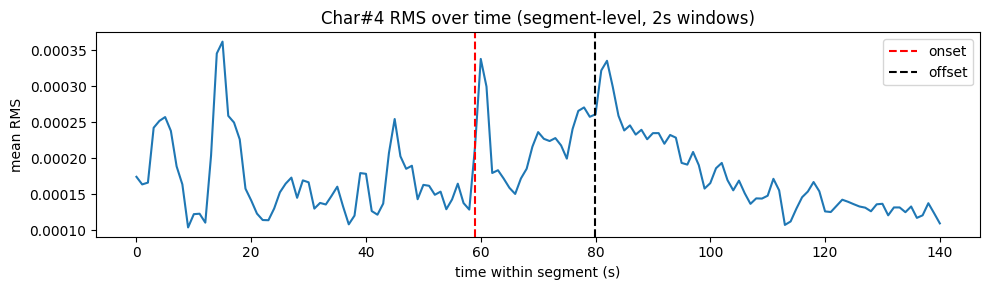

Heavy EDA summary rows: 3


,subject,acq,run,sfreq,n_total_channels,n_picks,duration_s,segment_tmin,segment_tmax,has_onset_offset,rms_mean,ptp_mean,spectral_entropy_mean,bp_mean_delta_1_4,bp_mean_theta_4_8,bp_mean_alpha_8_13,bp_mean_beta_13_30,bp_mean_gamma_30_80,bp_mean_hfo_80_150,hj_activity_mean,hj_mobility_mean,hj_complexity_mean
0,jh101,ecog,1,1000.0,135,16,142.199,0.0,142.199,True,0.000146,0.001461,2.606864,6.699102e-09,3.211270e-09,7.308501e-10,1.117586e-09,5.945917e-10,1.907253e-11,2.304806e-08,0.050026,17.258942
1,jh101,ecog,2,1000.0,135,16,338.174,0.0,338.174,True,0.000142,0.001596,3.115259,3.477284e-09,7.573172e-10,3.928019e-10,3.601795e-10,9.566037e-11,1.651010e-11,1.137880e-08,0.102613,12.731111
2,jh101,ecog,3,1000.0,135,16,142.199,0.0,142.199,True,0.000196,0.001608,2.322975,1.069395e-08,3.047944e-09,8.708737e-10,1.386313e-09,4.769568e-10,2.043021e-11,3.820581e-08,0.054953,17.565133


In [8]:
assert mne is not None and welch is not None, (
    'Thiếu mne hoặc scipy. Cài bằng: pip install mne scipy',
)

records = []

for i, row in heavy_runs.reset_index(drop=True).iterrows():
    base = str(row['base'])
    p = paths_from_base(base)
    vhdr_path = p['vhdr']
    if not vhdr_path.exists() or not is_valid_brainvision_vhdr(vhdr_path):
        print(f'[{i}] Skip (vhdr missing/invalid):', vhdr_path)
        continue

    ch_df = read_channels_tsv(p['channels'])
    picks = pick_good_ieeg_channels(ch_df, max_channels=MAX_CHANNELS)

    try:
        raw = mne.io.read_raw_brainvision(vhdr_path, preload=False, verbose='ERROR')
    except Exception as e:
        print(f'[{i}] Failed to load:', vhdr_path, type(e).__name__, e)
        continue

    sfreq = float(raw.info['sfreq'])
    n_total = len(raw.ch_names)
    duration_s = float(raw.times[-1])

    # Determine onset/offset
    onset = float(row.get('seizure_onset_s', np.nan))
    offset = float(row.get('seizure_offset_s', np.nan))
    has_window = (not np.isnan(onset)) and (not np.isnan(offset)) and (offset > onset)

    if has_window:
        tmin = max(0.0, onset - PRE_SEC)
        tmax = min(duration_s, offset + POST_SEC)
    else:
        # fallback: first 5 minutes
        tmin = 0.0
        tmax = min(duration_s, 300.0)

    seg = raw.copy().crop(tmin=tmin, tmax=tmax)
    seg.load_data()

    # Map picks to existing channel names
    if len(picks) == 0:
        picks = seg.ch_names[:min(MAX_CHANNELS, len(seg.ch_names))]
    else:
        picks = [ch for ch in picks if ch in set(seg.ch_names)]
        picks = picks[:min(MAX_CHANNELS, len(picks))]

    data, times = seg.get_data(picks=picks, return_times=True)
    # data: (n_channels, n_samples)

    # ---- Characteristic 1: scale & artifacts
    rms = np.sqrt(np.mean(data ** 2, axis=1))
    ptp = np.ptp(data, axis=1)

    title = (
        f"Char#1 RMS per channel | subject={row.get('subject','')}, "
        f"acq={row.get('acq','')}, run={row.get('run','')}"
    )
    plt.figure(figsize=(10, 3))
    plt.bar(np.arange(len(picks)), rms)
    plt.title(title)
    plt.xlabel('channel index')
    plt.ylabel('RMS')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.bar(np.arange(len(picks)), ptp)
    plt.title('Char#1 Peak-to-peak per channel')
    plt.xlabel('channel index')
    plt.ylabel('ptp')
    plt.tight_layout()
    plt.show()

    # ---- Characteristic 2: spectral content (PSD + bandpower)
    # Use 10s chunk from the middle of segment for speed
    mid = data.shape[1] // 2
    n10 = int(min(data.shape[1], sfreq * 10))
    s0 = max(0, mid - n10 // 2)
    s1 = min(data.shape[1], s0 + n10)
    x = data[:, s0:s1]

    band_defs = {
        'delta_1_4': (1, 4),
        'theta_4_8': (4, 8),
        'alpha_8_13': (8, 13),
        'beta_13_30': (13, 30),
        'gamma_30_80': (30, 80),
        'hfo_80_150': (80, 150),
    }

    # PSD for first few channels
    plt.figure(figsize=(10, 4))
    for ci in range(min(3, x.shape[0])):
        freqs, pxx = welch(x[ci], fs=sfreq, nperseg=min(len(x[ci]), int(sfreq * 2)))
        plt.semilogy(freqs, pxx, alpha=0.8, label=picks[ci])
    plt.xlim(0, 200)
    plt.title('Char#2 PSD (first 3 channels, ~10s excerpt)')
    plt.xlabel('Hz')
    plt.ylabel('Power')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Bandpower + entropy features aggregated across channels
    bp = {k: [] for k in band_defs}
    ent = []
    for ci in range(x.shape[0]):
        freqs, pxx = welch(x[ci], fs=sfreq, nperseg=min(len(x[ci]), int(sfreq * 2)))
        ent.append(spectral_entropy(pxx))
        for name, (fmin, fmax) in band_defs.items():
            bp[name].append(compute_bandpower(pxx, freqs, fmin, fmax))

    bp_mean = {f'bp_mean_{k}': float(np.nanmean(v)) for k, v in bp.items()}
    ent_mean = float(np.nanmean(ent))

    # ---- Characteristic 3: temporal dependence/complexity (Hjorth)
    hj = [hjorth_parameters(x[ci]) for ci in range(x.shape[0])]
    hj = np.array(hj)  # (n_ch, 3)
    hj_mean = {
        'hj_activity_mean': float(np.nanmean(hj[:, 0])),
        'hj_mobility_mean': float(np.nanmean(hj[:, 1])),
        'hj_complexity_mean': float(np.nanmean(hj[:, 2])),
    }

    # ---- Characteristic 4: non-stationarity around seizure (feature-over-time)
    # Compute RMS over sliding windows in segment (coarse)
    win = int(max(1, sfreq * 2))
    step = int(max(1, sfreq * 1))
    rms_t = []
    t_t = []
    for s in range(0, data.shape[1] - win + 1, step):
        w = data[:, s:s+win]
        rms_t.append(float(np.nanmean(np.sqrt(np.mean(w ** 2, axis=1)))))
        t_t.append(float(times[s]))

    plt.figure(figsize=(10, 3))
    plt.plot(t_t, rms_t)
    if has_window:
        plt.axvline(onset - tmin, color='r', linestyle='--', label='onset')
        plt.axvline(offset - tmin, color='k', linestyle='--', label='offset')
    plt.title('Char#4 RMS over time (segment-level, 2s windows)')
    plt.xlabel('time within segment (s)')
    plt.ylabel('mean RMS')
    if has_window:
        plt.legend()
    plt.tight_layout()
    plt.show()

    records.append({
        'subject': row.get('subject', ''),
        'acq': row.get('acq', ''),
        'run': row.get('run', ''),
        'sfreq': sfreq,
        'n_total_channels': n_total,
        'n_picks': len(picks),
        'duration_s': duration_s,
        'segment_tmin': tmin,
        'segment_tmax': tmax,
        'has_onset_offset': bool(has_window),
        'rms_mean': float(np.nanmean(rms)),
        'ptp_mean': float(np.nanmean(ptp)),
        'spectral_entropy_mean': ent_mean,
        **bp_mean,
        **hj_mean,
    })

summary_heavy = pd.DataFrame.from_records(records)
print('Heavy EDA summary rows:', len(summary_heavy))
display(summary_heavy)

## 5) Dataset shape (windowing) + feature set (demo)

Ở bước này, ta biến mỗi run thành một tập window. Đây là cách trả lời trực tiếp:
- Input shape (raw): `(n_windows, n_channels, n_samples)`
- Input shape (features): `(n_windows, n_features)`
- Output: `y` theo window (ictal/non-ictal hoặc 3-class)

Để chạy nhanh, notebook sẽ:
- chỉ lấy `MAX_CHANNELS` kênh good ECOG/SEEG
- chỉ lấy segment quanh seizure nếu có onset/offset, hoặc 5 phút đầu
- trích features đơn giản: RMS, line length, Hjorth, bandpower (mean over channels)

In [9]:
def line_length(x: np.ndarray) -> float:
    return float(np.sum(np.abs(np.diff(x))))


def extract_window_features(window: np.ndarray, sfreq: float) -> dict[str, float]:
    # window: (n_channels, n_samples)
    rms_ch = np.sqrt(np.mean(window ** 2, axis=1))
    ptp_ch = np.ptp(window, axis=1)

    ll_ch = np.array([line_length(window[i]) for i in range(window.shape[0])], dtype=float)
    hj = np.array([hjorth_parameters(window[i]) for i in range(window.shape[0])], dtype=float)

    # PSD features on first channel only (speed); can be expanded later
    freqs, pxx = welch(window[0], fs=sfreq, nperseg=min(window.shape[1], int(sfreq * 2)))
    feats = {
        'rms_mean': float(np.mean(rms_ch)),
        'ptp_mean': float(np.mean(ptp_ch)),
        'line_length_mean': float(np.mean(ll_ch)),
        'hj_activity_mean': float(np.mean(hj[:, 0])),
        'hj_mobility_mean': float(np.mean(hj[:, 1])),
        'hj_complexity_mean': float(np.mean(hj[:, 2])),
        'spec_entropy_ch0': spectral_entropy(pxx),
        'bp_1_4_ch0': compute_bandpower(pxx, freqs, 1, 4),
        'bp_4_8_ch0': compute_bandpower(pxx, freqs, 4, 8),
        'bp_8_13_ch0': compute_bandpower(pxx, freqs, 8, 13),
        'bp_13_30_ch0': compute_bandpower(pxx, freqs, 13, 30),
        'bp_30_80_ch0': compute_bandpower(pxx, freqs, 30, 80),
    }
    return feats


def window_and_label(data: np.ndarray, sfreq: float,
                     onset_in_segment: float | None,
                     offset_in_segment: float | None,
                     window_sec: float, step_sec: float) -> tuple[pd.DataFrame, np.ndarray]:
    # data: (n_channels, n_samples), times assumed start at 0 within segment
    n_samples = data.shape[1]
    win = int(round(window_sec * sfreq))
    step = int(round(step_sec * sfreq))
    rows = []
    y = []

    for start in range(0, n_samples - win + 1, step):
        end = start + win
        t0 = start / sfreq
        t1 = end / sfreq
        w = data[:, start:end]
        feats = extract_window_features(w, sfreq)
        feats['t_start'] = t0
        feats['t_end'] = t1

        label = 0  # non-ictal
        if onset_in_segment is not None and offset_in_segment is not None:
            # mark ictal if window overlaps [onset, offset]
            if (t1 > onset_in_segment) and (t0 < offset_in_segment):
                label = 1
        y.append(label)
        rows.append(feats)

    X = pd.DataFrame(rows)
    return X, np.asarray(y, dtype=int)

In [10]:
assert mne is not None and welch is not None, 'Need mne + scipy to build window features.'

demo_rows = []
X_list = []
y_list = []

for i, row in heavy_runs.reset_index(drop=True).iterrows():
    base = str(row['base'])
    p = paths_from_base(base)
    vhdr_path = p['vhdr']
    if not vhdr_path.exists() or not is_valid_brainvision_vhdr(vhdr_path):
        continue

    ch_df = read_channels_tsv(p['channels'])
    picks = pick_good_ieeg_channels(ch_df, max_channels=MAX_CHANNELS)

    try:
        raw = mne.io.read_raw_brainvision(vhdr_path, preload=False, verbose='ERROR')
    except Exception:
        continue

    sfreq = float(raw.info['sfreq'])
    duration_s = float(raw.times[-1])

    onset = float(row.get('seizure_onset_s', np.nan))
    offset = float(row.get('seizure_offset_s', np.nan))
    has_window = (not np.isnan(onset)) and (not np.isnan(offset)) and (offset > onset)

    if has_window:
        tmin = max(0.0, onset - PRE_SEC)
        tmax = min(duration_s, offset + POST_SEC)
        onset_seg = onset - tmin
        offset_seg = offset - tmin
    else:
        tmin = 0.0
        tmax = min(duration_s, 300.0)
        onset_seg = None
        offset_seg = None

    seg = raw.copy().crop(tmin=tmin, tmax=tmax)
    seg.load_data()

    if len(picks) == 0:
        picks = seg.ch_names[:min(MAX_CHANNELS, len(seg.ch_names))]
    else:
        picks = [ch for ch in picks if ch in set(seg.ch_names)]
        picks = picks[:min(MAX_CHANNELS, len(picks))]

    data = seg.get_data(picks=picks)
    data = data.astype(np.float32)

    X, y = window_and_label(data, sfreq, onset_seg, offset_seg, WINDOW_SEC, STEP_SEC)
    X['subject'] = row.get('subject', '')
    X['acq'] = row.get('acq', '')
    X['run'] = row.get('run', '')
    X['base'] = base

    X_list.append(X)
    y_list.append(pd.Series(y, name='y'))

    demo_rows.append({
        'subject': row.get('subject', ''),
        'run': row.get('run', ''),
        'sfreq': sfreq,
        'n_channels': data.shape[0],
        'n_samples_segment': data.shape[1],
        'segment_sec': data.shape[1] / sfreq,
        'window_sec': WINDOW_SEC,
        'step_sec': STEP_SEC,
        'n_windows': len(X),
        'n_features': X.shape[1] - 4,  # excluding subject/acq/run/base
        'y_pos': int(np.sum(y)),
        'y_neg': int(len(y) - np.sum(y)),
    })

demo_info = pd.DataFrame(demo_rows)
display(demo_info)

if len(X_list) > 0:
    X_all = pd.concat(X_list, ignore_index=True)
    y_all = pd.concat(y_list, ignore_index=True)
    print('X_all shape:', X_all.shape)
    print('y_all shape:', y_all.shape)
    print('y positive rate:', float(y_all.mean()) if len(y_all) > 0 else float('nan'))
    display(X_all.head())

Reading 0 ... 142199  =      0.000 ...   142.199 secs...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12292\2210648023.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[mask], freqs[mask]))


Reading 0 ... 338174  =      0.000 ...   338.174 secs...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12292\2210648023.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[mask], freqs[mask]))


Reading 0 ... 142199  =      0.000 ...   142.199 secs...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12292\2210648023.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[mask], freqs[mask]))


,subject,run,sfreq,n_channels,n_samples_segment,segment_sec,window_sec,step_sec,n_windows,n_features,y_pos,y_neg
0,jh101,1,1000.0,16,142200,142.200,2.0,1.0,141,14,23,118
1,jh101,2,1000.0,16,338175,338.175,2.0,1.0,337,14,211,126
2,jh101,3,1000.0,16,142200,142.200,2.0,1.0,141,14,23,118


X_all shape: (619, 18)
y_all shape: (619,)
y positive rate: 0.41518578352180935


,rms_mean,ptp_mean,line_length_mean,hj_activity_mean,hj_mobility_mean,hj_complexity_mean,spec_entropy_ch0,bp_1_4_ch0,bp_4_8_ch0,bp_8_13_ch0,bp_13_30_ch0,bp_30_80_ch0,t_start,t_end,subject,acq,run,base
0,0.000145,0.000695,0.006512,1.522319e-08,0.065101,15.726333,1.790210,9.003598e-10,2.334849e-10,6.064778e-11,7.915502e-11,2.818738e-11,0.0,2.0,jh101,ecog,1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
1,0.000124,0.000448,0.006023,8.608832e-09,0.065511,15.448452,2.779894,1.396951e-09,4.550401e-10,1.115382e-10,4.716101e-11,3.793211e-11,1.0,3.0,jh101,ecog,1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
2,0.000117,0.000479,0.006194,9.084782e-09,0.069717,14.108164,1.610876,2.200058e-09,3.868906e-10,1.620787e-10,5.623912e-11,3.736565e-11,2.0,4.0,jh101,ecog,1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
3,0.000125,0.000483,0.006933,1.160601e-08,0.063285,14.307559,2.111234,2.042647e-09,3.014842e-10,8.099218e-11,6.893764e-11,4.198537e-11,3.0,5.0,jh101,ecog,1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
4,0.000128,0.000479,0.006865,1.072322e-08,0.064089,13.538729,3.012264,3.207256e-10,1.849814e-10,7.827341e-11,1.164416e-10,5.586740e-11,4.0,6.0,jh101,ecog,1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...


## 6) Export outputs

Xuất các bảng summary/features để bạn đưa vào report hoặc train baseline model.

In [ ]:
out_dir = Path('eda_outputs')
out_dir.mkdir(exist_ok=True)

if 'summary_heavy' in globals() and isinstance(summary_heavy, pd.DataFrame) and len(summary_heavy) > 0:
    out1 = out_dir / 'ds003029_signal_eda_heavy_summary.csv'
    summary_heavy.to_csv(out1, index=False)
    print('Wrote:', out1.resolve())

if 'demo_info' in globals() and isinstance(demo_info, pd.DataFrame) and len(demo_info) > 0:
    out2 = out_dir / 'ds003029_windowing_demo_info.csv'
    demo_info.to_csv(out2, index=False)
    print('Wrote:', out2.resolve())

if 'X_all' in globals():
    feats = X_all.assign(y=y_all.values)

    out3_csv = out_dir / 'ds003029_window_features_demo.csv'
    feats.to_csv(out3_csv, index=False)
    print('Wrote:', out3_csv.resolve())

    out3_pkl = out_dir / 'ds003029_window_features_demo.pkl'
    feats.to_pickle(out3_pkl)
    print('Wrote:', out3_pkl.resolve())

    out3_parquet = out_dir / 'ds003029_window_features_demo.parquet'
    try:
        feats.to_parquet(out3_parquet, index=False)
        print('Wrote:', out3_parquet.resolve())
    except Exception as e:
        # Parquet is optional (needs pyarrow or fastparquet).
        print('Skipped parquet:', type(e).__name__, e)

Wrote: C:\Users\LENOVO\Downloads\eeg\eda_outputs\ds003029_signal_eda_heavy_summary.csv
Wrote: C:\Users\LENOVO\Downloads\eeg\eda_outputs\ds003029_windowing_demo_info.csv
Could not write parquet (missing engine?). Try: pip install pyarrow
Error: ImportError Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.


## 7) Report bullets (copy/paste)

Gợi ý bullet để đưa vào báo cáo (bạn chỉnh số liệu theo output):

- **Input/shape**: “We represent iEEG as sliding windows of length 2s with 1s stride. Raw input per window has shape $(C, T)$ where $C$ is the number of channels (limited to 16 good ECOG/SEEG channels) and $T$ is the number of samples (e.g., $T = 2 × f_s$). We also extract a feature vector per window (RMS, line length, Hjorth parameters, spectral entropy, bandpower), yielding an input matrix of shape $(N, F)$.”
- **Output/label**: “Labels are derived from BIDS `events.tsv` seizure onset/offset markers. Each window is labeled ictal if it overlaps the [onset, offset] interval; otherwise it is labeled non-ictal.”
- **4 characteristics**:
  1) Scale/artifacts: “Amplitude statistics (RMS/peak-to-peak) vary substantially across channels; a subset of channels show unusually high/low energy, suggesting potential artifacts or poor contact.”
  2) Spectral: “PSD shows energy concentrated in low frequencies with visible line-noise components; bandpower features across canonical bands provide discriminative summaries.”
  3) Temporal dependence: “Hjorth mobility/complexity and spectral entropy capture temporal smoothness/irregularity differences across windows.”
  4) Non-stationarity: “Feature trajectories over time reveal non-stationary behavior and changes around seizure intervals, supporting window-based labeling and change detection.”